In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
!pip install xgboost
import xgboost as xgb
!pip install catboost

from catboost import CatBoostClassifier
!pip install lightgbm

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (ExtraTreesClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA 

In [2]:
train_emoticon_df = pd.read_csv("train_emoticon.csv")
dummy = train_emoticon_df['input_emoticon'].tolist()
train_Y = train_emoticon_df['label']

# Load validation data
valid_emoticon_df = pd.read_csv("valid_emoticon.csv")
valid_Y = valid_emoticon_df['label']

# Load test data
test_emoticon_df = pd.read_csv("test_emoticon.csv")

In [3]:
train_emoticon_df.head()


,input_emoticon,label
0,😛🛐😻😑😣🙠🙯🚼😒🙼😑🙯😣,0
1,🛐😑😪😛🚼🙯😣🚅😑🙯😹😣🙼,0
2,😛🙯😑🚡😣🚼🛐🙲😣🙯🛑😑🙼,0
3,😛🚼🛐🙐😣🙯😑🙪😑🙼🛆😣🙯,1
4,🛐🚟🚼😛🙋😑😣🙯😹🙯😑😣🙼,1


In [4]:
def preprocess_emoticons(emoticons):
    return [[c for c in emoticon] for emoticon in emoticons]

In [5]:
train_emoticon_X = pd.DataFrame(preprocess_emoticons(train_emoticon_df['input_emoticon']))
valid_emoticon_X = pd.DataFrame(preprocess_emoticons(valid_emoticon_df['input_emoticon']))

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
enc = OneHotEncoder(handle_unknown='ignore')

# Fit on training data
enc.fit(train_emoticon_X)

# Transform train and validation data
train_X = enc.transform(train_emoticon_X)
valid_X = enc.transform(valid_emoticon_X)

In [8]:
train_X.shape

(7080, 2159)

In [9]:
def tune_and_evaluate(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_X, train_Y)
    best_model = grid_search.best_estimator_
    valid_pred = best_model.predict(valid_X)
    valid_acc = accuracy_score(valid_Y, valid_pred)
    return grid_search.best_params_, valid_acc, best_model

In [10]:
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}
log_reg = LogisticRegression(max_iter=5000)
log_reg_params, log_reg_acc, best_log_reg = tune_and_evaluate(log_reg, log_reg_param_grid)

In [11]:
print(log_reg_acc)
print(log_reg_params)

0.9161554192229039
{'C': 100, 'solver': 'lbfgs'}


In [12]:
from sklearn.svm import SVC
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']  }
svm_model = SVC()
svm_params, svm_acc, best_svm_model = tune_and_evaluate(svm_model, svm_param_grid)

In [13]:
print(svm_acc)
print(svm_params)

0.8916155419222904
{'C': 10, 'kernel': 'linear'}


In [14]:
from sklearn.neighbors import KNeighborsClassifier


In [15]:
knn_param_grid = {
    'n_neighbors': [1,5,10,15],
    'weights' : ['uniform','distance']
}
knn = KNeighborsClassifier()
knn_params, knn_acc, knn_model = tune_and_evaluate(knn, knn_param_grid)

In [16]:
print(knn_acc)
print(knn_params)

0.5480572597137015
{'n_neighbors': 10, 'weights': 'uniform'}


In [17]:
from sklearn.neighbors import RadiusNeighborsClassifier


In [18]:
enn_param_grid = {
    'radius' : [1.0, 5.0 , 10.0 ,15.0 ],
    'weights' : ['uniform', 'distance']
}
enn = RadiusNeighborsClassifier()
enn_params, enn_acc, enn_model = tune_and_evaluate(enn, enn_param_grid)

C:\Users\nikit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5079096  0.51016949 0.50508475 0.50508475
 0.50508475 0.50508475]
  warnings.warn(


In [19]:
print(enn_acc)
print(enn_params)

0.5194274028629857
{'radius': 5.0, 'weights': 'distance'}


In [20]:
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_params, xgb_acc, best_xgb_model = tune_and_evaluate(xgb_model, xgb_param_grid)

In [21]:
print(xgb_acc)
print(xgb_params)

0.7995910020449898
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}


In [22]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_model = RandomForestClassifier()
rf_params, rf_acc, best_rf_model = tune_and_evaluate(rf_model, rf_param_grid)

In [23]:
print(rf_acc)
print(rf_params)

0.852760736196319
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [24]:
extra_trees_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
extra_trees_model = ExtraTreesClassifier()
extra_trees_params, extra_trees_acc, best_extra_trees_model = tune_and_evaluate(extra_trees_model, extra_trees_param_grid)

In [25]:
print(extra_trees_acc)
print(extra_trees_params)

0.8548057259713702
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [26]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64),activation='tanh',learning_rate='adaptive', learning_rate_init=0.001, max_iter=1000)
mlp.fit(train_X, train_Y)
print(mlp.score(valid_X, valid_Y))


0.8916155419222904


In [27]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [35]:
base_models = [
    ('logreg', best_log_reg),
    ('svm',best_svm_model),
    ('rf', best_rf_model),
    ('extra_trees',best_extra_trees_model),
    ('mlp', mlp)
]

In [37]:
meta_learner = LogisticRegression()
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_learner)
stacking_clf.fit(train_X, train_Y)
stacking_pred = stacking_clf.predict(valid_X)
stacking_acc = accuracy_score(valid_Y, stacking_pred)

print(f"Validation Accuracy (Stacking): {stacking_acc:.4f}")

Validation Accuracy (Stacking): 0.9202


In [38]:
stacking_pred

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,

In [39]:
from sklearn.ensemble import VotingClassifier

In [40]:
voting_clf = VotingClassifier(estimators=[
    ('logreg', best_log_reg),
    ('svm',best_svm_model),
    ('rf', best_rf_model),
    ('extra_trees',best_extra_trees_model),
    ('mlp', mlp),
], voting='hard')

In [41]:
voting_clf.fit(train_X, train_Y)
voting_pred = voting_clf.predict(valid_X)
voting_acc = accuracy_score(valid_Y, voting_pred)

print(f"Validation Accuracy (Voting Classifier): {voting_acc:.4f}")

Validation Accuracy (Voting Classifier): 0.9202


In [42]:
train_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

def plot_accuracy_vs_data(model, name, color):
    results = []
    for pct in train_percentages:
      if pct == 1.0:
        model.fit(train_X, train_Y)
        valid_pred = model.predict(valid_X)
        acc = accuracy_score(valid_Y, valid_pred)
        results.append(acc)
      else:
        train_X_subset, _, train_Y_subset, _ = train_test_split(train_X, train_Y, train_size=pct, random_state=42)
        model.fit(train_X_subset, train_Y_subset)
        valid_pred = model.predict(valid_X)
        acc = accuracy_score(valid_Y, valid_pred)
        results.append(acc)
    plt.plot([p * 100 for p in train_percentages], results, marker='o', label=name,c=color)

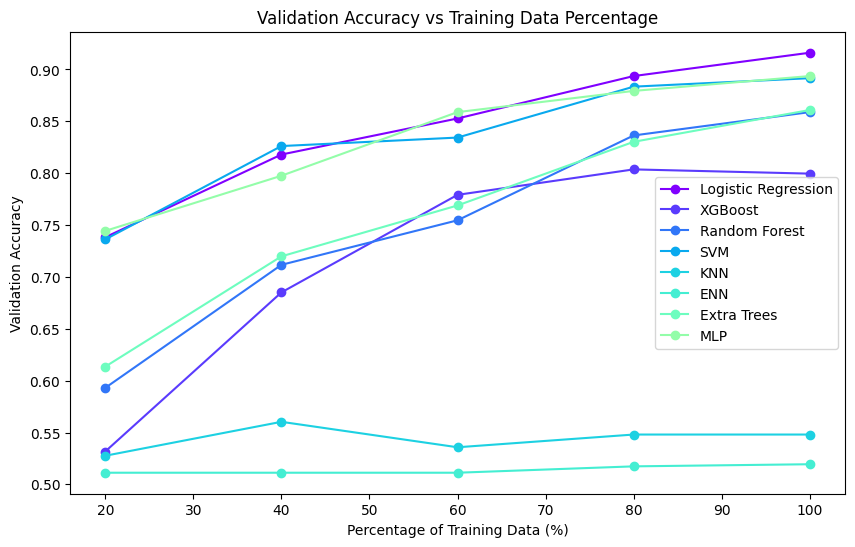

In [45]:
from matplotlib.pyplot import cm
plt.figure(figsize=(10, 6))
color = iter(cm.rainbow(np.linspace(0, 1, 14)))
c = next(color)
plot_accuracy_vs_data(best_log_reg, 'Logistic Regression', c)
c = next(color)
plot_accuracy_vs_data(best_xgb_model, 'XGBoost', c)
c = next(color)
plot_accuracy_vs_data(best_rf_model, 'Random Forest', c)
c = next(color)

plot_accuracy_vs_data(best_svm_model, 'SVM', c)
c = next(color)

plot_accuracy_vs_data(knn_model, 'KNN', c)
c = next(color)
plot_accuracy_vs_data(enn_model, 'ENN', c)
c = next(color)

plot_accuracy_vs_data(best_extra_trees_model, 'Extra Trees', c)
c = next(color)
plot_accuracy_vs_data(mlp, 'MLP', c)
c = next(color)
plt.xlabel("Percentage of Training Data (%)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Training Data Percentage")
plt.legend()
plt.show()

In [47]:
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Random Forest','SVM', 'KNN','ENN','Extra Trees','MLP'],
    'Validation Accuracy': [log_reg_acc, xgb_acc, rf_acc,  svm_acc,  knn_acc, enn_acc,  extra_trees_acc,  mlp.score(valid_X, valid_Y)],
})

models_comparison.sort_values(by = 'Validation Accuracy', ascending = False)

,Model,Validation Accuracy
0,Logistic Regression,0.916155
7,MLP,0.893661
3,SVM,0.891616
6,Extra Trees,0.854806
2,Random Forest,0.852761
1,XGBoost,0.799591
4,KNN,0.548057
5,ENN,0.519427
